In [134]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from epsilon_transformers.processes import RRXOR, ZeroOneR, Mess3

from epsilon_transformers.markov_utilities import (
    calculate_sequence_probabilities,
    compute_myopic_entropy_from_MSP,
    epsilon_machine_to_graph,
    get_recurrent_subgraph,
    to_mixed_state_presentation,
    get_recurrent_subgraph,
    calculate_empirical_sequence_probabilities,
    create_transition_matrix,
)
from epsilon_transformers.entropy_analysis import (
    compute_conditional_entropy,
    compute_empirical_conditional_entropy,
    inverse_binary_entropy,
)
from epsilon_transformers.error_analysis import (
    compute_minimum_error,
)
from epsilon_transformers.visualization import visualize_graph

from epsilon_transformers.simple_transformer import (
    MultilayerTransformer,
    train_model,
    initialize_weights,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# The Random-Random-XOR Process

## Visualizing the Epsilon Machine
Let's start with visualizing the Epsilon Machine

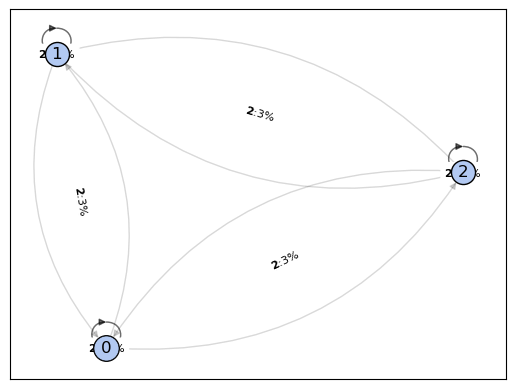

In [135]:
RRXORp = Mess3()  # RRXOR()#ZeroOneR()
# RRXOR()

# visualize the epsilon machine
graph = epsilon_machine_to_graph(RRXORp.transition_matrix)
visualize_graph(graph, draw_mixed_state=True)

## Mixed State Presentation

now let's compute the mixed state presentation and visualize it

In [136]:
MSP = to_mixed_state_presentation(RRXORp.transition_matrix, threshold=1e-5)
G_MSP = epsilon_machine_to_graph(MSP)
visualize_graph(
    G_MSP,
    layout="spring",
    draw_edge_labels=False,
    draw_mixed_state=True,
    draw_color=True,
)

resizing
resizing
resizing
resizing
resizing
resizing
resizing
resizing


KeyboardInterrupt: 

now let's extract the recurrent part of the MSP, hopefully this should leave us with a HMM that is isomorphic to the original process

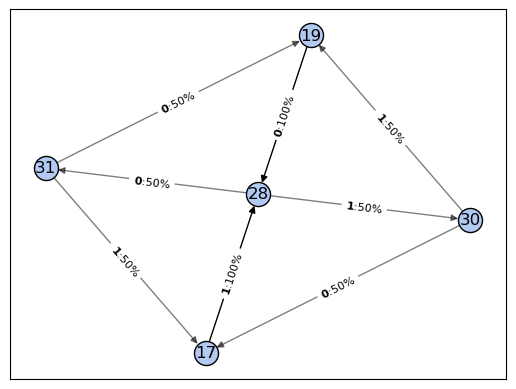

In [130]:
recurrent_subgraph = get_recurrent_subgraph(G_MSP)
visualize_graph(
    recurrent_subgraph, draw_edge_labels=True, draw_mixed_state=True, draw_color=False
)

## Myopic Entropy

plot the myopic entropy diagram

Text(0.5, 1.0, 'RRXOR Myopic Entropy')

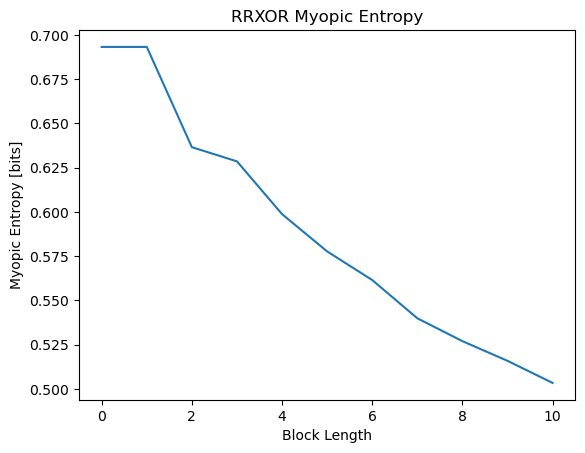

In [133]:
# myopic entropy
plt.plot(compute_myopic_entropy_from_MSP(MSP, 11))
plt.ylabel("Myopic Entropy [bits]")
plt.xlabel("Block Length")
plt.title("RRXOR Myopic Entropy")

## Length-L word Distribution

Now we will compute word distributions at different lengths

In [110]:
import pandas as pd

seq_probs = calculate_sequence_probabilities(RRXORp.transition_matrix, 20)
data = []
for length, sequences in seq_probs.items():
    for sequence, probability in sequences.items():
        data.append(
            {"length": length, "sequence": sequence, "probability": probability}
        )

df = pd.DataFrame(data)
len10 = df.query("length == 10").sort_values("probability", ascending=False)
print(len10.probability.sum())

1.0000000000000002


In [111]:
seq_probs[2]

defaultdict(float,
            {'00': 0.25,
             '01': 0.25000000000000006,
             '10': 0.25000000000000006,
             '11': 0.25})

In [120]:
from collections import defaultdict

sequence_length = 10  # Define the length of the sequence
seq_probs = calculate_sequence_probabilities(
    RRXORp.transition_matrix, sequence_length + 1
)
sequence_length_probs = seq_probs[
    sequence_length + 1
]  # dict where key is sequence and value is probability
sequence_inputs = list(sequence_length_probs.keys())  # Get the sequence inputs
test_weights = list(sequence_length_probs.values())  # Get the test weights

rng = np.random.default_rng()
batch_size = 1000
num_epochs = 10000
distribution = rng.multinomial(batch_size, test_weights, size=num_epochs)

epoch = 0
train_weights = distribution[epoch]  # Get the weights for the current epoch

d = train_weights
# d is a list of counts for each sequence
# and the sum of d is equal to batch_size
# and sequence_inputs is a list of sequences
# now we want to create a list of sequences according to the counts in d

# create a list of sequences according to the counts in d
sequence_to_index = {seq: i for i, seq in enumerate(sequence_inputs)}

X, Y = [], []
X_prob, Y_prob, prob = [], [], []
for i, count in enumerate(d):
    X.extend([sequence_inputs[i][:-1]] * count)
    Y.extend([sequence_inputs[i][1:]] * count)
    X_prob.extend(sequence_inputs[i][:-1])
    Y_prob.extend(sequence_inputs[i][1:])
    prob.extend([count / batch_size])


# for each X,Y pair, count the number of them
# and then divide by the total number of X,Y pairs
counter = defaultdict(int)
for x, y in zip(X, Y):
    counter[(x, y)] += 1


for i, seq in enumerate(sequence_inputs):
    x = seq[:-1]
    y = seq[1:]
    count = counter.get((x, y), 0)
    # print(f"i: {i}, seq: {seq}, d[i]: {d[i]}, X: {x}, Y: {y}, X_prob: {X_prob[i]}, Y_prob: {Y_prob[i]}, prob: {prob[i]}, Count: {count}, Probability: {count/batch_size}")
    print(
        f"i: {i}, d[i]: {d[i]},   prob: {prob[i]}, Count: {count}, Probability: {count/batch_size}"
    )

i: 0, d[i]: 0,   prob: 0.0, Count: 0, Probability: 0.0
i: 1, d[i]: 2,   prob: 0.002, Count: 2, Probability: 0.002
i: 2, d[i]: 2,   prob: 0.002, Count: 2, Probability: 0.002
i: 3, d[i]: 3,   prob: 0.003, Count: 3, Probability: 0.003
i: 4, d[i]: 3,   prob: 0.003, Count: 3, Probability: 0.003
i: 5, d[i]: 3,   prob: 0.003, Count: 3, Probability: 0.003
i: 6, d[i]: 2,   prob: 0.002, Count: 2, Probability: 0.002
i: 7, d[i]: 0,   prob: 0.0, Count: 0, Probability: 0.0
i: 8, d[i]: 2,   prob: 0.002, Count: 2, Probability: 0.002
i: 9, d[i]: 0,   prob: 0.0, Count: 0, Probability: 0.0
i: 10, d[i]: 2,   prob: 0.002, Count: 2, Probability: 0.002
i: 11, d[i]: 1,   prob: 0.001, Count: 1, Probability: 0.001
i: 12, d[i]: 0,   prob: 0.0, Count: 0, Probability: 0.0
i: 13, d[i]: 0,   prob: 0.0, Count: 0, Probability: 0.0
i: 14, d[i]: 1,   prob: 0.001, Count: 1, Probability: 0.001
i: 15, d[i]: 6,   prob: 0.006, Count: 6, Probability: 0.006
i: 16, d[i]: 3,   prob: 0.003, Count: 3, Probability: 0.003
i: 17, d[i

In [127]:
sequence_length = 10  # Define the length of the sequence
seq_probs = calculate_sequence_probabilities(
    RRXORp.transition_matrix, sequence_length + 1
)
sequence_length_probs = seq_probs[
    sequence_length + 1
]  # dict where key is sequence and value is probability
sequence_inputs = list(sequence_length_probs.keys())  # Get the sequence inputs
test_weights = list(
    sequence_length_probs.values()
)  # Get the test weights size (num_sequences,)

rng = np.random.default_rng()
batch_size = 1000
num_epochs = 10000
distribution = rng.multinomial(
    batch_size, test_weights, size=num_epochs
)  # (num_epochs, num_sequences)

seqs = np.array(
    [np.array([int(x) for x in sequence]) for sequence in sequence_inputs]
)  # (num_sequences, sequence_length+1)
X = seqs[:, 1:]  # (num_sequences, sequence_length)
Y = seqs[:, :-1]  # (num_sequences, sequence_length)

# convert distribution to weights
train_weights = distribution / batch_size  # (num_epochs, num_sequences)

In [ ]:
from collections import defaultdict

sequence_length = 10  # Define the length of the sequence
seq_probs = calculate_sequence_probabilities(RRXORp.transition_matrix, sequence_length+1)
sequence_length_probs = seq_probs[sequence_length+1]  # dict where key is sequence and value is probability
sequence_inputs = list(sequence_length_probs.keys())  # Get the sequence inputs
test_weights = list(sequence_length_probs.values())  # Get the test weights

# turn sequence input into a numpy array
sequence_inputs = np.array(sequence_inputs)

rng = np.random.default_rng()
batch_size = 1000
num_epochs = 10000
distribution = rng.multinomial(batch_size, test_weights, size=num_epochs)

epoch=0
train_weights = distribution[epoch]  # Get the weights for the current epoch

d=train_weights
# d is a list of counts for each sequence
# and the sum of d is equal to batch_size
# and sequence_inputs is a list of sequences
# now we want to create a list of sequences according to the counts in d

for d in distribution:


X, Y = [], []
X_prob, Y_prob, prob = [], [], []
for i, count in enumerate(d):
    X.extend([sequence_inputs[i][:-1]] * count)
    Y.extend([sequence_inputs[i][1:]] * count)
    X_prob.extend(sequence_inputs[i][:-1])
    Y_prob.extend(sequence_inputs[i][1:])
    prob.extend([count/batch_size])


# for each X,Y pair, count the number of them
# and then divide by the total number of X,Y pairs
counter = defaultdict(int)
for x,y in zip(X,Y):
    counter[(x,y)] += 1


for i, seq in enumerate(sequence_inputs):
    x = seq[:-1]
    y = seq[1:]
    count = counter.get((x, y), 0)
    #print(f"i: {i}, seq: {seq}, d[i]: {d[i]}, X: {x}, Y: {y}, X_prob: {X_prob[i]}, Y_prob: {Y_prob[i]}, prob: {prob[i]}, Count: {count}, Probability: {count/batch_size}")
    print(f"i: {i}, d[i]: {d[i]},   prob: {prob[i]}, Count: {count}, Probability: {count/batch_size}")


In [103]:
len(counter)

40

In [37]:
df.query("length == 10").sort_values("probability", ascending=False)

,length,sequence,probability
652,10,0110110110,0.006510
695,10,1011011011,0.006510
610,10,0000000000,0.006510
737,10,1101101101,0.006510
697,10,1011011101,0.005208
...,...,...,...
816,10,1101111010,0.001302
841,10,1111001111,0.001302
818,10,1110100000,0.001302
819,10,1110100001,0.001302


In [12]:
def calculate_probabilities(df, length):
    # Get the length and length + 1 data
    df_length = df[df["length"] == length]
    df_length_plus_one = df[df["length"] == length + 1]

    # Initialize a dictionary to store the probabilities
    probabilities = {"sequence": [], "prob(0)": [], "prob(1)": []}

    # For each length sequence
    for sequence in df_length["sequence"]:
        # Get the probabilities of emitting a 0 or a 1 from the length + 1 data
        prob_0 = df_length_plus_one["probability"][
            df_length_plus_one["sequence"].str.startswith(sequence + "0")
        ].sum()
        prob_1 = df_length_plus_one["probability"][
            df_length_plus_one["sequence"].str.startswith(sequence + "1")
        ].sum()

        # Normalize the probabilities so they sum to 1
        total_prob = prob_0 + prob_1
        if total_prob > 0:
            prob_0 /= total_prob
            prob_1 /= total_prob

        # Add the probabilities to the dictionary
        probabilities["sequence"].append(sequence)
        probabilities["prob(0)"].append(prob_0)
        probabilities["prob(1)"].append(prob_1)

    # Convert the dictionary to a DataFrame
    df_new = pd.DataFrame(probabilities)
    # sort the dataframe by the probability of emitting a 0
    df_new = df_new.sort_values("prob(0)", ascending=False)
    return df_new


df_new = calculate_probabilities(df, 10)
df_new

,sequence,prob(0),prob(1)
336,1010110100,1.0,0.0
264,0101110100,1.0,0.0
288,0111001100,1.0,0.0
135,0000010111,1.0,0.0
287,0111000011,1.0,0.0
...,...,...,...
133,0000010101,0.0,1.0
130,0000001110,0.0,1.0
293,0111010101,0.0,1.0
128,0000000010,0.0,1.0


## Building Processes from length-L histories

If we build a process using length 3 histories as states, what does that look like, what does the MSP look like, and what does the recurrent portion of the MSP look like?


The length-3 world length process has this many states:  8  and looks like this: 


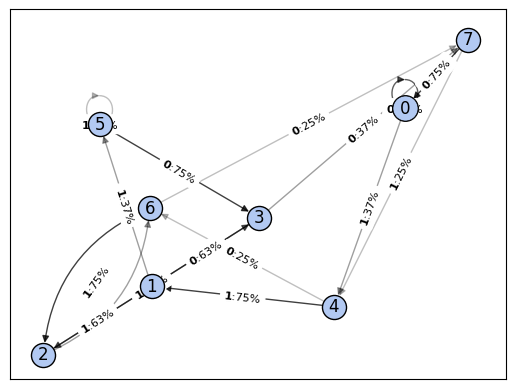

the MSP has this many states:  15  and looks like this: 


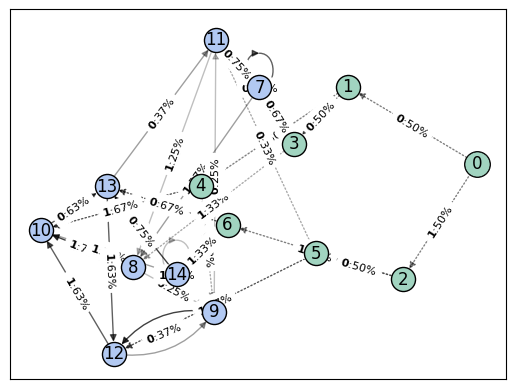

the recurrent subgraph has this many states:  8  and looks like this: 


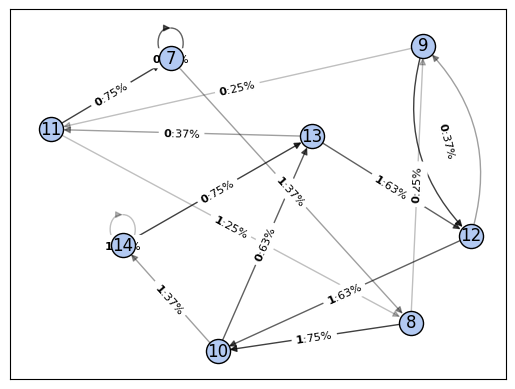

In [9]:
state_names, T, eprobs = create_transition_matrix(seq_probs, 3)
G = epsilon_machine_to_graph(T)
print(
    "The length-3 world length process has this many states: ",
    len(state_names),
    " and looks like this: ",
)
visualize_graph_with_selective_offset(
    G, layout="spring", draw_edge_labels=True, draw_color=False, draw_mixed_state=True
)
MSP = to_mixed_state_presentation(T, threshold=1e-5)
print("the MSP has this many states: ", MSP.shape[1], " and looks like this: ")
G_MSP = epsilon_machine_to_graph(MSP)
visualize_graph_with_selective_offset(
    G_MSP,
    layout="spring",
    draw_edge_labels=True,
    draw_color=False,
    draw_mixed_state=True,
)
recur = get_recurrent_subgraph(G_MSP)
print(
    "the recurrent subgraph has this many states: ",
    len(recur.nodes),
    " and looks like this: ",
)
visualize_graph_with_selective_offset(
    recur,
    layout="spring",
    draw_edge_labels=True,
    draw_color=False,
    draw_mixed_state=True,
)

## MSP of the MSP? why not

the MSP of the MSP has this many states:  15  and looks like this: 


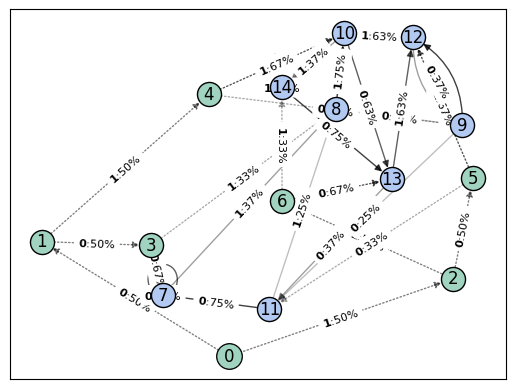

the recurrent subgraph has this many states:  8  and looks like this: 


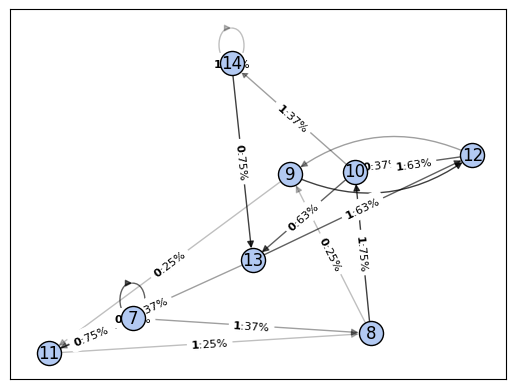

In [10]:
# make an MSP of the MSP
MSP_MSP = to_mixed_state_presentation(MSP, threshold=1e-5)
print(
    "the MSP of the MSP has this many states: ",
    MSP_MSP.shape[1],
    " and looks like this: ",
)
G_MSP_MSP = epsilon_machine_to_graph(MSP_MSP)
visualize_graph_with_selective_offset(
    G_MSP_MSP,
    layout="spring",
    draw_edge_labels=True,
    draw_color=False,
    draw_mixed_state=True,
)
# get recurrent
recurrent_subgraph = get_recurrent_subgraph(G_MSP_MSP)
print(
    "the recurrent subgraph has this many states: ",
    len(recurrent_subgraph.nodes),
    " and looks like this: ",
)
visualize_graph_with_selective_offset(
    recurrent_subgraph,
    layout="spring",
    draw_edge_labels=True,
    draw_color=False,
    draw_mixed_state=True,
)

## Creating data, feeding it into a Transformer to Train

In [62]:
# Define a config for the transformer and training
config = {
    # transformer config
    "d_vocab": 2,
    "d_model": 64,
    "input_size": 10,  # context length
    "d_head": 2 * 16,
    "n_head": 2,
    "d_mlp": 4 * 64,
    "n_layers": 1,
    # training config
    "batch_size": 1024,
    "sequence_length": 50000,
    "num_epochs": 300,
    "learning_rate": 1.5e-2,
    "weight_decay": 0.0,
    "patience": 1000,
    "factor": 0.5,
}

# Generate sequence data with positions
train_loader, test_loader, sequence_positions = RRXORp.prepare_data(
    config["sequence_length"],
    config["input_size"],
    split_ratio=0.8,
    batch_size=config["batch_size"],
    with_positions=True,
)

print(f"The number of batches in the training set is {len(train_loader)}")

# Model Definition
model = MultilayerTransformer(
    d_vocab=config["d_vocab"],
    d_model=config["d_model"],
    input_size=config["input_size"],
    d_head=config["d_head"],
    n_head=config["n_head"],
    d_mlp=config["d_mlp"],
    n_layers=config["n_layers"],
)
model.apply(initialize_weights)
# Check if CUDA is available and move the model to GPU if it is
if torch.cuda.is_available():
    model = model.cuda()
print("CUDA Available:", torch.cuda.is_available())

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"]
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, patience=config["patience"], factor=config["factor"], verbose=True
)

# Training
model = train_model(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    scheduler,
    num_epochs=config["num_epochs"],
    verbose=True,
)

The number of batches in the training set is 40
CUDA Available: False
| Epoch | Training Accuracy | Loss | Overall Accuracy | Last Bit Accuracy | Last Bit Loss |
|   1   |      71.78%       | 1.0014 |      72.68%      |      72.89%      | 1.0000 |
|   2   |      72.69%       | 0.9983 |      71.44%      |      71.41%      | 1.0149 |
|   3   |      71.72%       | 0.9903 |      79.48%      |      75.54%      | 1.0022 |
|   4   |      72.74%       | 0.9866 |      81.14%      |      71.48%      | 1.0030 |
|   5   |      72.49%       | 0.9499 |      86.28%      |      75.43%      | 0.9964 |
|   6   |      75.97%       | 0.9855 |      86.36%      |      78.77%      | 1.0086 |
|   7   |      82.33%       | 0.9621 |      88.65%      |      85.29%      | 0.9584 |
|   8   |      83.95%       | 0.9326 |      86.55%      |      83.51%      | 0.9625 |
|   9   |      83.72%       | 0.9605 |      87.62%      |      85.43%      | 0.9671 |
|  10   |      83.77%       | 0.9556 |      87.10%      |      8

In [59]:
# define loss function as cross entropy loss, but no reduction
crossEntropy = nn.CrossEntropyLoss(reduction="none")

model.eval()
with torch.no_grad():
    # For train data
    train_loss = []
    train_accuracy = []
    for data, target in train_loader:
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        output = model(data)
        loss = crossEntropy(output.view(-1, 2), target.view(-1))
        # Reshape loss back to original shape before saving
        train_loss.append(loss.view(data.shape[0], data.shape[1]).cpu().numpy())
        # prediction is argmax over last dimension, which is 2
        pred = output.data.max(2, keepdim=True)[1]
        correct = pred.squeeze() == data
        train_accuracy.append(correct.cpu().numpy())

    # For test data
    test_loss = []
    test_accuracy = []
    for data, target in test_loader:
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        output = model(data)
        loss = crossEntropy(output.view(-1, 2), target.view(-1))
        test_loss.append(loss.view(data.shape[0], data.shape[1]).cpu().numpy())
        pred = output.data.max(2, keepdim=True)[1]
        correct = pred.squeeze() == data
        test_accuracy.append(correct.cpu().numpy())


train_loss = np.concatenate(train_loss)
train_accuracy = np.concatenate(train_accuracy)
test_loss = np.concatenate(test_loss)
test_accuracy = np.concatenate(test_accuracy)

print("Train Loss: ", np.mean(train_loss))
print("Train Accuracy: ", np.mean(train_accuracy))
print("Test Loss: ", np.mean(test_loss))
print("Test Accuracy: ", np.mean(test_accuracy))

Train Loss:  0.65419304
Train Accuracy:  0.4720190380761523
Test Loss:  0.65713996
Test Accuracy:  0.467935871743487


In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# make the seaborn context prettier
sns.set_context("talk")


# Reshape the data to long format
train_loss_df = pd.DataFrame(train_loss).melt(
    var_name="context_position", value_name="loss"
)
train_loss_df["type"] = "train"
test_loss_df = pd.DataFrame(test_loss).melt(
    var_name="context_position", value_name="loss"
)
test_loss_df["type"] = "test"

# add 1 to context pos
train_loss_df["context_position"] += 1
test_loss_df["context_position"] += 1

# convert to bits from nats
train_loss_df["loss"] = np.log2(np.exp(train_loss_df["loss"]))
test_loss_df["loss"] = np.log2(np.exp(test_loss_df["loss"]))

# Concatenate the dataframes
loss_df = pd.concat([train_loss_df, test_loss_df])

/Users/adamimos/anaconda3/envs/epsilon-machine/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/adamimos/anaconda3/envs/epsilon-machine/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


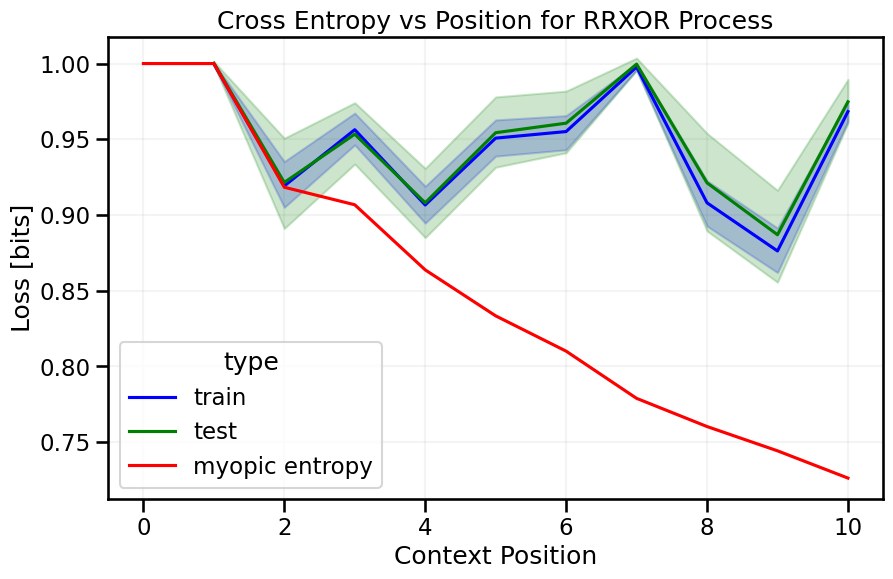

In [61]:
# Compute myopic entropy
myopic_entropy = compute_myopic_entropy_from_MSP(MSP, 11)

# Create a DataFrame for myopic entropy
myopic_entropy_df = pd.DataFrame(
    {
        "context_position": np.arange(len(myopic_entropy)),
        "loss": myopic_entropy,
        "type": "myopic entropy",
    }
)

# Concatenate the dataframes
loss_df = pd.concat([train_loss_df, test_loss_df, myopic_entropy_df])

# Define colors for each line
colors = {"train": "blue", "test": "green", "myopic entropy": "red"}

# Plot using seaborn
plt.figure(figsize=(10, 6))
plt.grid(True)  # Add a grid for better readability
# make grid lighter
plt.gca().set_axisbelow(True)
plt.grid(which="major", color="#999999", linestyle="-", alpha=0.1)
sns.lineplot(data=loss_df, x="context_position", y="loss", hue="type", palette=colors)
plt.ylabel("Loss [bits]")
plt.xlabel("Context Position")
plt.title("Cross Entropy vs Position for RRXOR Process")
plt.show()

In [50]:
# define loss function as cross entropy loss, but no reduction
crossEntropy = nn.CrossEntropyLoss(reduction="none")

model.eval()
model.register_hooks()

with torch.no_grad():
    # For train data
    train_loss = []
    train_accuracy = []
    for data, target in train_loader:
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        output = model(data)

        for i, hook_output in enumerate(model.hooks):
            print(f"Output of layer {i}: {hook_output}")

        loss = crossEntropy(output.view(-1, 2), target.view(-1))
        # Reshape loss back to original shape before saving
        train_loss.append(loss.view(data.shape[0], data.shape[1]).cpu().numpy())
        # prediction is argmax over last dimension, which is 2
        pred = output.data.max(2, keepdim=True)[1]
        correct = pred.squeeze() == data
        train_accuracy.append(correct.cpu().numpy())

AttributeError: 'MultilayerTransformer' object has no attribute 'register_hooks'

In [1]:
model.hooks

NameError: name 'model' is not defined